### Détectection des faux billets avec Python

## 1. Preliminary

     *** Contexte ***

Identification des contrefaçons des billets en euros

Les billets d'euro ont des valeurs nominales de 5, 10, 20, 50, 100, 200 et 500 euros. 

In [100]:
!python -V


Python 3.9.13


## 1.1 Install

In [101]:
#

# 1.2 Importation

## 1.2.1 Importation des librairies

In [102]:
#builtin
import os

In [103]:

#data
import pandas as pd
import numpy as np

In [104]:

#visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
%matplotlib inline

In [105]:
#machine learning
from sklearn.linear_model import LinearRegression

## 2.1 chargement des fichiers

In [106]:
input_folder = r"C:\Users\Nada\Desktop\OpenClassRooms\Projet 10\Data\0 Source"
# Read CSV train data file into DataFrame
train_df= pd.read_csv(os.path.join(input_folder, "billets.csv"), dtype=float, sep=';')
# Read CSV test data file into DataFrame
test_df = pd.read_csv(os.path.join(input_folder, "billets_production.csv"), sep=',')


## 2. Prétraitement des données

## 2.2 Exploration

In [107]:
#Affichage des 5 premieres lignes
train_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


In [108]:
print('The number of samples into the train data is {}.'.format(train_df.shape[0]))

The number of samples into the train data is 1500.


In [109]:
# preview test data
test_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [110]:
print('The number of samples into the test data is {}.'.format(test_df.shape[0]))

The number of samples into the test data is 5.


Note: there is no target variable into test data (i.e. "is_genuine" column is missing), so the goal is to predict this target using different machine learning algorithms such as logistic regression.

In [111]:
#Affichage des 5 dernieres lignes
train_df.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,0.0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0.0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0.0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0.0,172.06,104.28,104.06,5.17,3.46,112.25
1499,0.0,171.47,104.15,103.82,4.63,3.37,112.07


In [112]:
#Affichage de 5 lignes arbitrairement
train_df.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
152,1.0,171.97,104.29,104.04,4.46,2.97,113.81
373,1.0,171.65,104.29,103.81,4.26,3.05,113.58
654,1.0,171.97,103.69,103.54,NaN,2.70,112.79
1285,0.0,172.12,104.38,103.93,4.71,3.44,111.52
1427,0.0,172.27,104.39,104.50,5.09,3.11,112.51


In [113]:
#Dimensions du DataFrame
train_df.shape

(1500, 7)

In [114]:
#Information sur les colonnes
train_df.dtypes

is_genuine      float64
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [115]:
#Statistiques descriptives
train_df.describe().round(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,0.67,171.96,104.03,103.92,4.49,3.15,112.68
std,0.47,0.31,0.30,0.33,0.66,0.23,0.87
min,0.00,171.04,103.14,102.82,2.98,2.27,109.49
25%,0.00,171.75,103.82,103.71,4.01,2.99,112.03
50%,1.00,171.96,104.04,103.92,4.31,3.14,112.96
75%,1.00,172.17,104.23,104.15,4.87,3.31,113.34
max,1.00,173.01,104.88,104.95,6.90,3.91,114.44


In [116]:
#Nombre des doublons dans le DataFrame
train_df.duplicated().sum()

0

In [117]:
#Nombre des doublons sans le target
train_df.drop(columns="is_genuine").duplicated().sum()

0

In [118]:
#Information sur les valeurs unique dans chaque colonne
train_df.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [119]:
#Nombre des valeurs dans la target
train_df['is_genuine'].value_counts()

is_genuine
1.0    1000
0.0     500
Name: count, dtype: int64

1=Vrais
0=faux

In [120]:
#creation de la colonne target
train_df.rename(columns={'is_genuine':'target'}, inplace=True)

On a 37 valeurs manquantes dans la colonne margin_low

## 2.3 Nettoyage des données

In [121]:
#Nombre des valeurs manquantes dans chaque colonne
train_df.isnull().sum()

target           0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [122]:
# Pourçentage des valeurs manquantes 
print('Percent of missing "margin_low" records is %.2f%%' %((train_df['margin_low'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "margin_low" records is 2.47%


~2,5% de donnée sur margin_low est manquantes. -> voir la distribution de cette variable

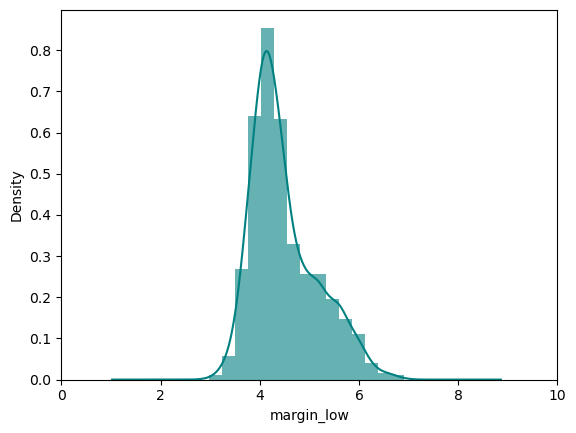

In [123]:
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

la mediane de margin_low est indique entre 4 et 5 mm. On va essayer la regression lineaire pour l'imputation des valeurs manquantes.

### 2.3.1 Imputation des valeurs manquantes

In [124]:
#Creation d'une copy de notre DataFrame
train_data=train_df.copy()

In [125]:
## elimination de la colonne target
#train_data.drop(['target'], axis=1, inplace=True)

On a un DataFrame qui contient X=6 (features)

## Regression lineaire

les valeurs manquantes sont de type numerique

#Choix de la methode regression lineaire pour l'imputation des valeurs manquantes

In [126]:
# Séparer les données en deux ensembles : avec et sans valeurs manquantes

test= train_data[train_data['margin_low'].isna()] #DataFrame qui contient que les valeurs manquantes

train = train_df[~train_data['margin_low'].isna()] #dataframe sans valeurs manquantes

In [127]:
test.shape

(37, 7)

In [128]:
train.shape

(1463, 7)

In [129]:
# Diviser les données en variables explicatives (X) et la variable cible (y)
#les variables explicative (X)
X_train = train.drop(columns=['margin_low'])
X_train

,target,diagonal,height_left,height_right,margin_up,length
0,1.0,171.81,104.86,104.95,2.89,112.83
1,1.0,171.46,103.36,103.66,2.99,113.09
2,1.0,172.69,104.48,103.50,2.94,113.16
3,1.0,171.36,103.91,103.94,3.01,113.51
4,1.0,171.73,104.28,103.46,3.48,112.54
...,...,...,...,...,...,...
1495,0.0,171.75,104.38,104.17,3.09,111.28
1496,0.0,172.19,104.63,104.44,3.37,110.97
1497,0.0,171.80,104.01,104.12,3.36,111.95
1498,0.0,172.06,104.28,104.06,3.46,112.25


In [130]:
# Diviser les données en variables explicatives (X) et la variable cible (y)
#la variable cible (y) (target)
y_train= train['margin_low']
y_train.shape

(1463,)

In [131]:
## Model
# Créer et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [132]:
#creation de la variable X_test
X_test = test.drop(columns=['margin_low'])

In [133]:
# Prédire les valeurs manquantes
y_predicted = model.predict(X_test)

In [134]:
y_predicted.shape

(37,)

In [135]:
# Remplacer les valeurs manquantes par les valeurs prédites
train_data.loc[train_data['margin_low'].isna(), 'margin_low'] = y_predicted

In [136]:
y_predicted

array([4.06495361, 4.11199026, 4.13400328, 3.99357074, 4.1403993 ,
       4.09428392, 4.07412432, 4.12538999, 4.0807278 , 4.07363322,
       4.11897255, 4.18037978, 4.13648423, 4.05106842, 4.17837685,
       4.22555104, 4.11586845, 4.10284101, 4.08184346, 4.09276238,
       4.11250192, 4.15717623, 4.16028787, 4.12193808, 4.12353555,
       4.19842271, 4.10962313, 4.09696025, 4.13384101, 5.25968515,
       5.264817  , 5.28251853, 5.30206887, 5.20035843, 5.1754678 ,
       5.17345045, 5.24675055])

In [137]:
y_predicted.shape

(37,)

In [138]:
#Verification
train_data.isnull().sum()

target          0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [139]:
# preview adjusted train data
train_data.head()

,target,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


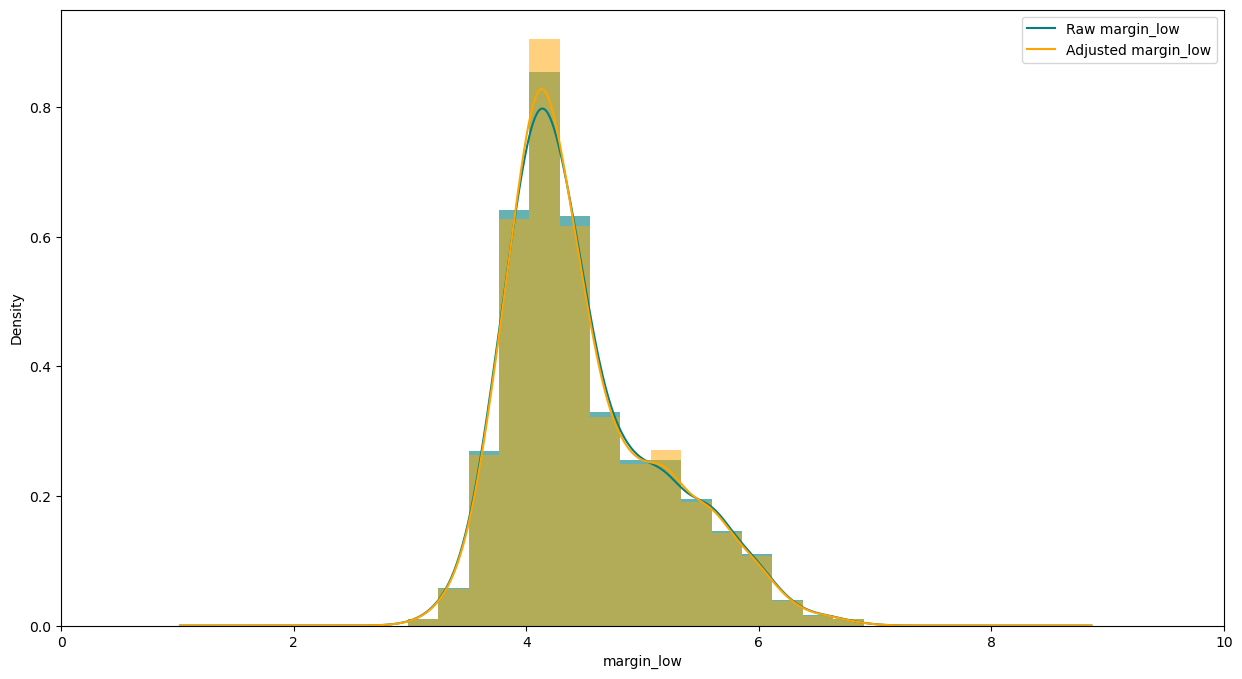

In [143]:
#Verification avec visualisation
plt.figure(figsize=(15,8))
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax = train_data["margin_low"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
train_data["margin_low"].plot(kind='density', color='orange')
ax.legend(['Raw margin_low', 'Adjusted margin_low'])
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

## 2.3.2 Detection des outliers

## 2.3.1.1 Data mining

## 2.4 Preparation des données